# Breast Cancer Detection with KNN - Classification Challenge

## Description

Breast cancer is the most common cancer amongst women in the world. It accounts for 25% of all cancer cases, and affected over 2.1 Million people in 2015 alone. It starts when cells in the breast begin to grow out of control. These cells usually form tumors that can be seen via X-ray or felt as lumps in the breast area.

The key challenges against it’s detection is how to classify tumors into malignant (cancerous) or benign(non cancerous). We ask you to complete the analysis of classifying these tumors using machine learning (with SVMs) and the Breast Cancer Wisconsin (Diagnostic) Dataset.

## Acknowledgements

This dataset has been referred from Kaggle.

## Objective

- Understand the Dataset & cleanup (if required).
- Build classification models to predict whether the cancer type is Malignant or Benign.
- Also fine-tune the hyperparameters & compare the evaluation metrics of various classification algorithms.

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression

## Load Dataset

In [3]:
dataset_path = './breast-cancer.csv'

df = pd.read_csv(dataset_path)

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

### Checking if the dataset is balance or unbalance

B -> benign     (non cancerous)
M -> malignant  (cancerous)

In [5]:
df.loc[:, ['id' ,'diagnosis']].groupby('diagnosis').count().reset_index()

,diagnosis,id
0,B,357
1,M,212


It can be seen that, this dataset is unbalanced because, the amount of malignant tumors is only 37% of the total but the benign tumors amount to 62%

This means that for the next steps, the solution for the correct classifications of the tumors must consider the dataset as unbalance, otherwise it may get bad results in the classifications of the tumors.

Here the interest group is M, the Malignant cells, so lets make it the positive case and B the negative case

In [6]:
df['target_encoded'] = df['diagnosis'].map({'M': 1, 'B': 0})

df['target_encoded'].head()

0    1
1    1
2    1
3    1
4    1
Name: target_encoded, dtype: int64

## Features Selection

In [7]:
# x = training_features
# y = label

features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'
       ]

label = 'target_encoded' #'diagnosis'

## Training

### Spliting the Data into -> Training, test, validate

Through Scikit-Lean it is used the function train_test_split() with Cross-Validation (5-Folds) to split the data in 80/20.
80 -> Training + Validation
20 ->Test

The spliting of the data is needed to make sure that the algorithm is correctly asnwearing/classifing the tumors, and not simply memorizing the answears.

Training Set: The model learns patterns and relationships from this data. The model sees and learns directly from this data to adjust its internal parameters (weights and biases).

Validation Set: Used to fine-tune the model's structure or hyperparameters (e.g., learning rate, number of layers) and compare candidate models. The model's performance on this data is evaluated frequently during development, but the model does not learn directly from it.

Test Set: Used to provide a final, unbiased evaluation of the chosen, fully-tuned model's ability to generalize to truly unseen data. This data is only used once, at the very end, and is kept completely isolated throughout the entire development process.

Risk if used incorrectly

- Training Set: Underfitting (if too small or not diverse) or Overfitting (if training is run too long).

- Validation Set: Overfitting to the validation set (if used too many times to guide design choices).

- Test Set: An overly optimistic or unreliable estimate of real-world performance.

In [ ]:
# Divides (Tain vs Test+Validation)
# First slipt. Tain - 80% ; Temp - 20%
x_train, x_test , y_train, y_test = train_test_split(
  df[features],
  df[label],
  test_size=0.2,
  random_state=42,
  stratify=df[label] # Keeps the proportion of M/B
)

# Split (Tain vs Validate) each 10% -> Grid Search already split the data to validate it
#x_validate, x_test, y_validade, y_test = train_test_split(
#  x_temp,
#  y_temp,
#  test_size=0.5,
#  random_state=42,
#  stratify=y_temp
#)

# Sizes
print(f'Train Set: {x_train.shape}')
#print(f'Validate Set: {x_validate.shape}')
print(f'Test Set: {x_test.shape}')

Train Set: (455, 30)
Test Set: (114, 30)


## KNN Training

### Finding best k for imbalanced dataset

#### Sensitivity-Specificity Metrics

Sensitivity refers to the true positive rate and summarizes how well the positive class was predicted.

$$
Sensitivity = \frac{TruePositive}{TruePositive + FalseNegative}
$$

Specificity is the complement to sensitivity, or the true negative rate, and summarises how well the negative class was predicted.

$$
Specificity = \frac{TrueNegative}{FalsePositive + TrueNegative}
$$

For imbalanced classification, the sensitivity might be more interesting than the specificity.

Sensitivity and Specificity can be combined into a single score that balances both concerns, called the geometric mean or G-Mean.

$$
G_Mean = sqrt(Sensitivity * Specificitu)
$$

Training the algorithm with KNN and validating it with the Grid Search Method to verify wich is the best K value (number of neighbors)

In [25]:
# Personalized metrics for specificity
def specificity_score(y_true, y_pred):
  return mt.recall_score(y_true, y_pred, pos_label=0)


# Dictionary of metrics to watch
scoring_metrics = {
  'sensitivity': 'recall', # recall and sensibility are synonimos
  'specificity': mt.make_scorer(specificity_score),
  'auc': 'roc_auc' # area under the curve
}

# Making Pipeline (Scaler + KNN)
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier())
])

# Defining hyperparameters
param_grid = {
              'knn__n_neighbors': list(range(1,21, 2)), # the ',2' avoids even numbers 
              'knn__weights': ['uniform', 'distance'], # weight of votes
              'knn__metric': ['euclidean', 'manhattan'], # type of distance
              }

# Initialize Grid Search with 5-fold Cross Validation
grid_search = GridSearchCV(
  estimator=pipeline,
  param_grid=param_grid,
  scoring=scoring_metrics, # All scoring_metrics used
  refit='sensitivity', # But the model is chosed based this metric
  cv=5, # 5-Fold Cross Validation
  verbose=1,
  n_jobs=-1
)

# Fit model on training data
grid_search.fit(x_train, y_train) # Grid Search makes the cross validation from these data


print(f'Best parameters found (Optimized for Sensitivity)')
print(grid_search.best_params_)

print(f"Best Score of Sensitivity (Mean CV): {grid_search.best_score_:.4f}")

# Acessing the detailed results to see the Specificity of winner model
results = grid_search.cv_results_
best_index = grid_search.best_index_
best_spec = results['mean_test_specificity'][best_index]

print(f'Sensitivity of best model: {best_spec:.4f}')


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found (Optimized for Sensitivity)
{'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
Best Score of Sensitivity (Mean CV): 0.9353
Sensitivity of best model: 0.9579


# Final Test
  - Now it's used the Test Set (data never seen by the model)
  - grid_search already choose the best model ('refit'), it is ready to predict

## Metrics

In [26]:
y_pred_knn_final = grid_search.predict(x_test)
y_proba_knn_final = grid_search.predict_proba(x_test)[:,1]


recall_knn = mt.recall_score(y_test, y_pred_knn_final)
specificity_knn = mt.recall_score(y_test, y_pred_knn_final, pos_label=0)
precision_knn = mt.precision_score(y_test, y_pred_knn_final)
f1_knn = mt.f1_score(y_test, y_pred_knn_final)
accuracy_knn = mt.accuracy_score(y_test,y_pred_knn_final)


print(f"KNN Final Recall (Sensitivity): {recall_knn:.4f}")
print(f"KNN Final Specificity: {specificity_knn:.4f}")
print(f"KNN Final Precision: {precision_knn:.4f}")
print(f"KNN Final F1 Score: {f1_knn:.4f}")
print(f'KNN Final Accuracy = {accuracy_knn:.4f}')

KNN Final Recall (Sensitivity): 0.9286
KNN Final Specificity: 0.9583
KNN Final Precision: 0.9286
KNN Final F1 Score: 0.9286
KNN Final Accuracy = 0.9474


Final Recall (Sensitivity):
  - This metric is responsible in telling if the correct identification of - Malignant tumors is good or not
  - In other words this metrics tell you the percentage of people who the model corretly identified as not okay

Specificity:
  - This metrics measures the correct identification of the Benigent tumors

Precision:
  - From all the times the model predict someone to have a Malignant tumor how often they actually had one

Accuracy:
  - The total percent of the time the models gets a correct prediction
  - This metric is not allways trustful, for example imagine the data had 100 people, 10 have cancer.
  - If I miss all this 10 people and said they were fine, I'd still score 90%
  - More used to compare classifications models/algorithms

F1 Score:
  - The harmonic mean of precision and recall

## Confusion Matrix

By default the Scikit-Learn orders the confusion matrix classes in ascending order.
As it is mapped 0 = B and 1 = M
For this matrix, first comes the B and afterwards M

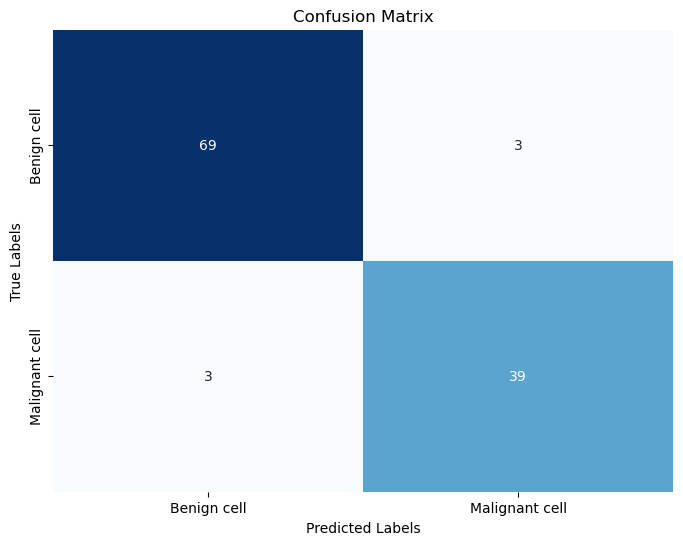

In [27]:
cm_knn = mt.confusion_matrix(y_test, y_pred_knn_final)

disp = mt.ConfusionMatrixDisplay(confusion_matrix=cm_knn)

#disp.plot(cmap=plt.cm.Blues)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5,1.5], ['Benign cell', 'Malignant cell'])
plt.yticks([0.5,1.5], ['Benign cell', 'Malignant cell'], va='center')
plt.show()

## ROC Curve

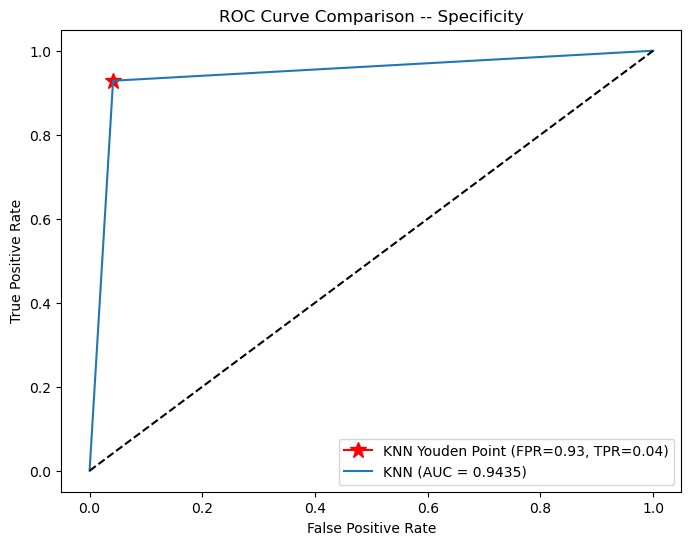

In [28]:
# KNN
  # get ROC curve values
  # Trating the malignant as positive, to better read the graph
fpr_knn, tpr_knn, _ = mt.roc_curve(y_test, y_proba_knn_final)
  # get areas under the curves
auc_knn = mt.roc_auc_score(y_test, y_proba_knn_final)

# Calculus of the Youden Index (J) for each point on the curve.
youden_j_knn = tpr_knn - fpr_knn

# Finding the index (position) where J is at its maximum.
optimal_idx = np.argmax(youden_j_knn)

# index to obtain the optimal threshold and corresponding rates.
optimal_tpr_knn = tpr_knn[optimal_idx]
optimal_fpr_knn = fpr_knn[optimal_idx]

# Logistic Regression
#  # get ROC curve values
#fpr_logreg, tpr_logreg, _ = mt.roc_curve(y_test, y_pred_logReg, pos_label='M')
#  # get areas under the curves
#auc_logreg = mt.roc_auc_score(y_test, y_pred_logReg)


plt.figure(figsize=(8,6))
plt.plot(optimal_fpr_knn, optimal_tpr_knn, marker='*', markersize=12, color='red', label=f'KNN Youden Point (FPR={optimal_tpr_knn:.2f}, TPR={optimal_fpr_knn:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.4f})')
#plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Reg. (AUC = {auc_logreg:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison -- Specificity')
plt.legend()
plt.show()

Another way to find the point closest to the upper left corner (coordinates 0,1) is by minimizing the Euclidean distance between the point (FPR, TPR) and the ideal point (0,1).

$$
Distance = \sqrt{(0-{FPR})^2+(1-{TPR})^2}
$$

In this scenario, choosing the optimal point isn't purely mathematical, it's a business decision (I prefer to say a life death situation) based on the cost of erros:

  - High Cost of FN (False Negative): Making a healthy patient undergo invasive tests. The model should prioritize Recall/Sensitivity (low TPR).
  - High Cost of FP (False Positive): Missing a malignant diagnosis. The model should prioritize Specificity (high FPR). This means the FPR is close to 1.0, even if the TPR increases slightly

## Precision-Recall Curve

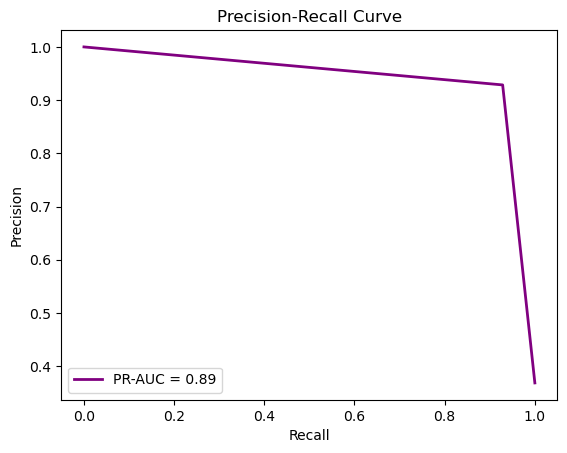

In [29]:
precision, recall, threshold_pr = mt.precision_recall_curve(y_test, y_proba_knn_final)

pr_auc = mt.average_precision_score(y_test, y_proba_knn_final)

# plot precision recall curve
plt.plot(recall, precision, color='purple', lw=2, label=f'PR-AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.show()

# Permutation Feature Importance

Como o KNN baseia-se em distância matemática, ele não nos diz nativamente "O Raio é mais importante que a Textura".
Para descobrir isso, usamos a Permutação:
  1. Pegamos o modelo treinado
  2. Embaralhamos os valores de uma coluna (ex: radius_mean) no teste, mantendo as outras intactas.
  3. Medimos o quanto a performance (ex: Recall) cai.
  4. Se cair muito, aquela variável era vital. Se não mudar anda, a variável era inútil.

Calculando importância das variáveis (pode demorar um pouco)...


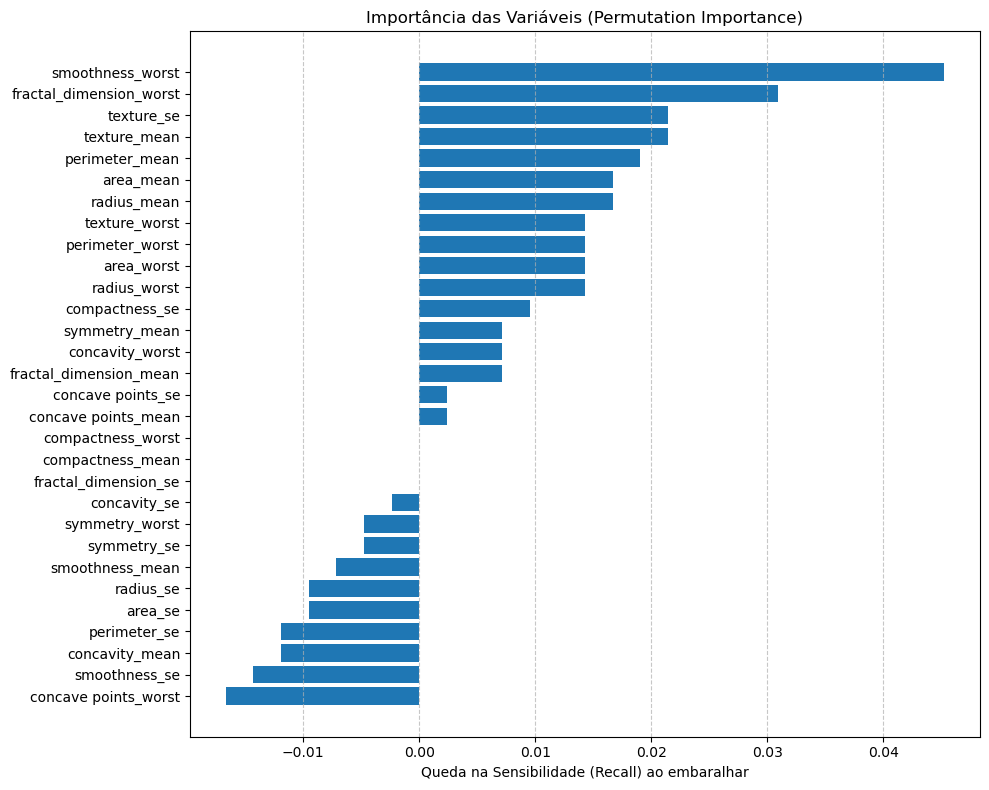

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# 1. Retrieve the best trained model from GridSearch
best_knn_model = grid_search.best_estimator_

# 2. Calculate the importance via permutation.
# Calculate the importance of vscoreing='recall': We want to know which variables affect the SENSITIVITY (detecting Cancer) in the permutation
# n_repeat=10: Repeats the shuffling 10 times to obtain robust statistics.
print('Calculating the importance of variables...')
perm_importance = permutation_importance(
  best_knn_model,
  x_test,
  y_test,
  n_repeats=10,
  random_state=42,
  scoring='recall'
)

# 3. Organize the data for plotting.
# The result shows the average performance drop (importances_mean).
sorted_idx = perm_importance.importances_mean.argsort()

# 4. Ploting the Horizontal Bar Chart
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx]) # Usa sua lista 'features'
plt.xlabel('Decreased Recall (Sensitivity) upon Shuffle')
plt.title('Importance of Variables (Permutation Importance)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**How ​​to interpret the generated graph?**
1. **Larger Bars**: These are the critical variables. If you remove them, the model stops detecting cancer correctly.

2. **Bars Close to Zero:** Variables that the model practically ignores (noise).

3. **Negative Bars (Rare):** This happens when shuffling the variable improves the model (meaning the original variable was interfering/Overfitting).

---

# Comparsion with DummyClassifier

In [31]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# --- 1. Defining Baseline Strategies ---

# Strategy 1: Always guess the majority class (0/Benign)
# Good for comparing accuracy.
dummy_major = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_major.fit(x_train, y_train)
y_pred_major = dummy_major.predict(x_test)

# Strategy 2: Always guess Cancer (1/Malignant) - What you suggested
# Good to see the "cost" of having 100% Recall (Accuracy plummets).
dummy_cancer = DummyClassifier(strategy="constant", constant=1, random_state=42)
dummy_cancer.fit(x_train, y_train)
y_pred_cancer = dummy_cancer.predict(x_test)

# --- 2. Auxiliary Comparison Function ---
def print_metrics(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, pos_label=1) # Focus on Malignant
    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    
    print(f"--- {model_name} ---")
    print(f"Accuracy:      {acc:.4f}")
    print(f"Sensitivity: {rec:.4f} (Did it detect cancer?)")
    print(f"Precision:      {prec:.4f}")
    print(f"F1-Score:      {f1:.4f}")
    print("-" * 30)

# --- 3. Performing the Comparisons ---

print("PERFORMANCE COMPARISON (KNN vs BASELINES)\n")

# KNN Metrics
print_metrics("KNN Optimized", y_test, y_pred_knn_final)

# Baseline Metrics 'Guess Majority'
print_metrics("BASELINE 1 (Guess Everything Benign)", y_test, y_pred_major)

# Metrics from the 'Guess It All Out Cancer' Baseline
print_metrics("BASELINE 2 (Guess Everything, Cancer)", y_test, y_pred_cancer)

PERFORMANCE COMPARISON (KNN vs BASELINES)

--- KNN Optimized ---
Accuracy:      0.9474
Sensitivity: 0.9286 (Did it detect cancer?)
Precision:      0.9286
F1-Score:      0.9286
------------------------------
--- BASELINE 1 (Guess Everything Benign) ---
Accuracy:      0.6316
Sensitivity: 0.0000 (Did it detect cancer?)
Precision:      0.0000
F1-Score:      0.0000
------------------------------
--- BASELINE 2 (Guess Everything, Cancer) ---
Accuracy:      0.3684
Sensitivity: 1.0000 (Did it detect cancer?)
Precision:      0.3684
F1-Score:      0.5385
------------------------------
